<a href="https://colab.research.google.com/github/teaminii/MachineLearning/blob/main/Lec18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import json
a = {'visual' : 5 , 'value2':10, 'seq':[1,2,3,4,5]}

filename = 'test.jason'
with open(filename, 'w') as f:
  json.dump(a, f)

with open(filename, 'r') as f:
  result = json.load(f)
  print(result)

{'visual': 5, 'value2': 10, 'seq': [1, 2, 3, 4, 5]}


In [52]:
## file name 만들기 
import hashlib
setting = {'visual':6 , 'value2':10, 'seq':[1,2,3,4,5], 'exp_name':'exp1'}
exp_name = setting['exp_name']
hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
filename = '{}-{}.json'.format(exp_name,hash_key)
print(filename)

exp1-84c0e5.json


In [53]:
!ls

data  results  sample_data  test.jason


In [54]:
!mkdir results
!ls
!ls results

mkdir: cannot create directory ‘results’: File exists
data  results  sample_data  test.jason
exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-dece45.json
exp1_n_layer_hid_dim-7b70fe.json  exp2_lr_dropout-404d92.json
exp1_n_layer_hid_dim-bfc899.json


In [55]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy 

In [56]:
#================ Data 다운받기 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [57]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # Linear Layer 생성
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # Activation Function 생성
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # Regularization Layer 생성
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Te

In [58]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [59]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [60]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [61]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # 초기화 
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch): 
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        ##Epoch Data 추가하기
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        ##
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # Result to Dictionary 추가하기
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [62]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)
    return df
    

In [63]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

args.optim = 'RMSprop'
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024


name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 37.70/36.71, Loss(train/val) 2.55/1.98. Took 9.20 sec
Epoch 1, Acc(train/val): 45.56/42.76, Loss(train/val) 1.58/1.75. Took 9.57 sec
Epoch 2, Acc(train/val): 48.69/44.60, Loss(train/val) 1.49/1.65. Took 10.42 sec
Epoch 3, Acc(train/val): 50.63/43.54, Loss(train/val) 1.44/1.74. Took 9.42 sec
Epoch 4, Acc(train/val): 52.70/40.85, Loss(train/val) 1.38/1.92. Took 9.71 sec
Epoch 5, Acc(train/val): 55.09/44.63, Loss(train/val) 1.32/1.81. Took 9.59 sec
Epoch 6, Acc(train/val): 56.33/43.62, Loss(train/val) 1.29/1.88. Took 9.61 sec
Epoch 7, Acc(train/val): 58.36/46.58, Loss(train/val) 1.23/1.74. Took 9.43 sec
Epoch 8, Acc(train/val): 59.67/41.35, Loss(train/val) 1.19/2.11. Took 9.49 sec
Epoch 9, Acc(train/val): 61.47/43.01, Loss(train/

In [66]:
!ls results

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-dece45.json
exp1_n_layer_hid_dim-7b70fe.json  exp2_lr_dropout-404d92.json
exp1_n_layer_hid_dim-bfc899.json


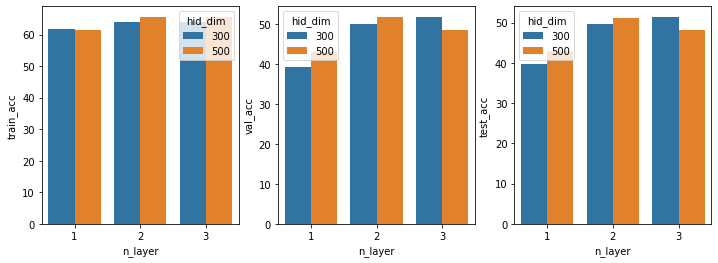

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

#load_exp_result('exp1')
#print(type(load_exp_result('exp1')))

df = load_exp_result('exp1')

fig, ax = plt.subplots(1,3)
fig.set_size_inches(12,4)

# a = [{'age':5, 'gender':'f', 'score':10, 't':1},{'age':6, 'gender':'m', 'score':9,'t':1},
#      {'age':10, 'gender':'f', 'score':15, 't':1},{'age':7, 'gender':'m', 'score':2, 't':2},
#      {'age':3, 'gender':'f', 'score':33, 't':2}]

# df = pd.DataFrame(a)
# df

# sns.relplot(x='age', y='gender', data=df)
# sns.barplot(x='age', y='score', hue='gender', data =df)

sns.barplot(x='n_layer', y='train_acc', hue = 'hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue = 'hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue = 'hid_dim', data=df, ax=ax[2])

[2 3 1] [500 300]


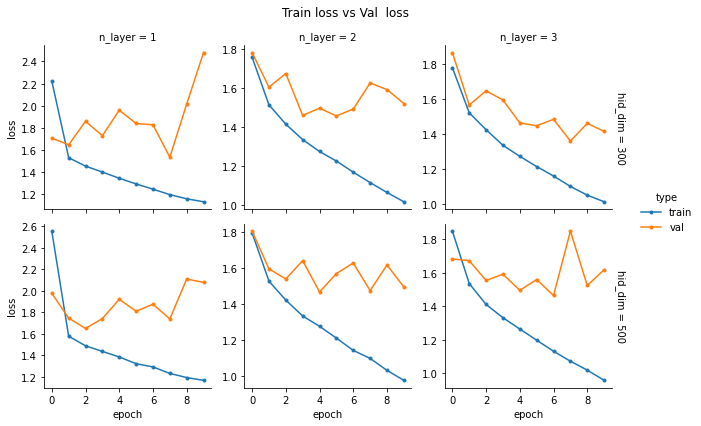

In [68]:
#================= Loss 변화

var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
print(list_v1, list_v2)
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val  loss')
plt.subplots_adjust(top=0.89)

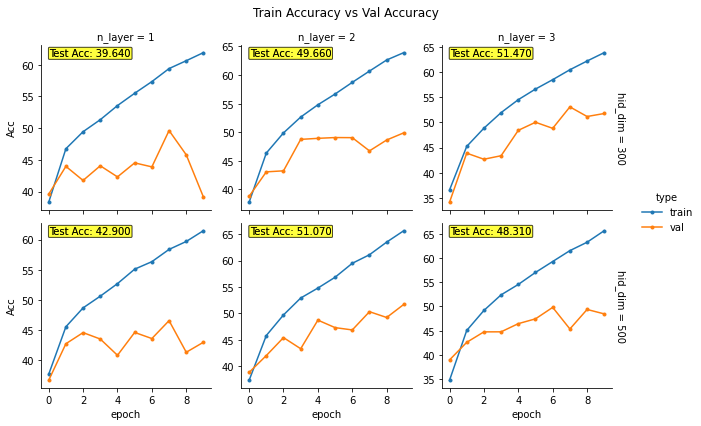

In [69]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [18]:
!pip install seaborn==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 208 kB 15.2 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [70]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr_dropout"

args.n_layer =3
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 300
args.act = 'relu'

#args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

args.optim = 'RMSprop' 
#args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.0005, 0.001, 0.005]
list_var2 = [0, 0.1,0.2,0.3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0, epoch=10, exp_name='exp2_lr_dropout', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0005, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 40.62/41.25, Loss(train/val) 1.66/1.65. Took 9.66 sec
Epoch 1, Acc(train/val): 49.85/45.34, Loss(train/val) 1.41/1.55. Took 9.76 sec
Epoch 2, Acc(train/val): 54.57/46.35, Loss(train/val) 1.28/1.52. Took 9.56 sec
Epoch 3, Acc(train/val): 58.12/48.45, Loss(train/val) 1.18/1.47. Took 9.81 sec
Epoch 4, Acc(train/val): 61.40/48.65, Loss(train/val) 1.09/1.48. Took 9.75 sec
Epoch 5, Acc(train/val): 64.22/51.28, Loss(train/val) 1.01/1.41. Took 9.59 sec
Epoch 6, Acc(train/val): 67.44/48.15, Loss(train/val) 0.93/1.56. Took 9.71 sec
Epoch 7, Acc(train/val): 70.28/50.97, Loss(train/val) 0.84/1.52. Took 9.80 sec
Epoch 8, Acc(train/val): 73.03/50.23, Loss(train/val) 0.77/1.59. Took 9.77 sec
Epoch 9, Acc(train/val): 75.82/50.14, Loss(train/val) 0.6